### First let's import everything we will need :

In [115]:
# My personnal helper classes to get the data :
from data_reader.data_reader import DataReader
from data_reader.helpers import locations, mean_diploma, mean_age

# A few standard libraries :
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Now describe & create all the datasets - with some reminders from the 'single dataset' notebooks.

### 1) The referendum data

This is the reason for our study, it contains all the results from the Referendum per town, giving numbers of suscribed voters, blank votes, abstention and votes for each proposition.

The **INSEE code has to be built back from Dept & City codes**. Keep in mind building it is necessary to have an unique identifier. Throughout this notebook use it as the DataFrame index.

This is the only dataset that also contains TOMs and French from abroad dataset. So far we keep all of it for the first few plots.

In total it reports the results from 36791 towns. 

Paris, Marseille and Lyon are reported as only one entry each. We will force the other datasets to use this too.

In [2]:
referendum = DataReader(
    path=locations("referendum"),
    insee_code=('Code du département','Code de la commune'),
    drop_domtom=False
).content()

I keep the reader to easily remove DomToms later.
Let's augment this with abstention

In [3]:
referendum["Abstention Totale"] = referendum["Abstentions"]+referendum["Blancs et nuls"]

### 2) The diploma data

The first dataframe only reads a simple dataset that allows to translate between the official nomenclature and clearer information (age, diploma, sex). The second one is the one of interest.

The **second dataset is the one we want to look into : it contains all the information on the education level of each town**, given as the number of people that achieved to graduate at each level. It is also split by gender and in two age class (16-24, >= 25)

There are **20 entries for Paris, one per Arrondissement. We sum all of their entries** into one. 
The survey reports over several years, we only look at 2012 (closest to the referendum). Due to town appearing or merging, there are some rows with no values - they are removed.

The impact of not having 2013 is not significant : less than 10 (small) towns aren't found in 2013's Referendum.

This **data is augmented computing a mean diploma level** per town. This level is computed from the age at which someone who didn't double would get a given diploma. It is set at 6 for people without diploma, and goes to 24. (There is some arbitrary in choice, but it may be better than using the median graduation age that could bake into it socio-economical problems, with people deciding to stop/come back to their studies for various reasons)

DOMs here (and in all INSEE data) have Dept code 97, different from the convention in the Referendum data ('Z*').

In [4]:
helper_df=DataReader(
    path=locations('diploma_helper'),
    sheet_name='Sheet1',
    sep=',',
    force_index='Unnamed: 0'
).content()

In [5]:
diplomas=DataReader(
    path=locations("diplomes"), 
    sheet_name='COM_2012',
    skiprows=16, 
    insee_code=('dr','cr'),
    drop_domtom=True,
    rm_nan=True, #Values sometime not filled due to (dis)appearing towns through the survey
    arrondissement_handling="Merge"
).content()

In [6]:
diplomas=diplomas.assign(MeanDiploma=lambda x: mean_diploma(x,helper_df))

### 3) The Recensement

This gives the number of inhabitants per town, further split per gender and age group. It also split wrt where people lived an year before, and socio-professional categories.

There are caveats to keep in mind : below 200 inhabitants, it should not be considered accurate and below 2000 the information socio-professional categories should not be used. This also holds for 'secondary information' derived from this recensement, i.e. diploma and revenue.

This dataset is augmented computing the mean age per town.

This provide information on the DOMs, not TOMs/Frenchs abroad.

In [7]:
recensement=DataReader(
    path=locations("recensement"), 
    sheet_name='COM_2013',
    drop_domtom=True,
    insee_code=('CODGEO',),
    skiprows=5 # Row nb. 6 will be the columns names
).content()

In [8]:
recensement=recensement.assign(MeanAge=mean_age)

### 4) Revenue data

This gives the **distribution of income in each town, for metropolitan france only**.
It includes the number of households, the median income, the poverty rate, the fraction of taxable households and the wage gap.

No information is given below 50 households and only median income & number of households between 50-1000.

For Paris,Marseille,Lyon only keep information at town level (also available per Arrondissement)

In [9]:
revenus=DataReader(
    path=locations("revenus"), 
    sheet_name='COM',
    skiprows=5, # Row nb. 6 will be the columns names
    insee_code=('CODGEO',),
    drop_domtom=True,
    arrondissement_handling="Delete"
).content()

### 5) Geographical data

**Contains the data of all French cities boundaries**. However it is from 2022 (past ones are removed), which means there is a fair number of towns that (dis)appeared.

820 towns have different names in this dataset and the Recensement, but matching INSEE codes. Most cases it seems to be only typing differences, but there are also towns merging and keeping one code.

18 towns are only found in the geographical data, it's impossible to know how many people this represents.

**1704 towns are seen only in the recensement, which makes 968976 people**. It is likely most of them would be found in town mergers, but checking this explicitely would require a deeper study. As it is ~1.5% of the population only, we keep it this way.

In [35]:
geo_data=DataReader(
    path=locations("geodata"),
    drop_domtom=True,
    insee_code=('insee',)
).content()
geo_data = geo_data.to_crs('EPSG:3395') #Mercator projection
geo_data

,nom,wikipedia,surf_ha,geometry
insee,,,,
2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((1037516.467 5190024.118, 1037528.712..."
2B137,Lano,fr:Lano,824.0,"POLYGON ((1024150.514 5190784.341, 1024154.766..."
2B051,Cambia,fr:Cambia,833.0,"POLYGON ((1032774.591 5188526.558, 1032775.259..."
2B106,Érone,fr:Érone,393.0,"POLYGON ((1029838.317 5188670.688, 1029852.454..."
2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((1033422.916 5231811.100, 1033429.194..."
...,...,...,...,...
80122,Bouquemaison,fr:Bouquemaison,724.0,"POLYGON ((257659.526 6454190.931, 257978.244 6..."
62795,Sibiville,fr:Sibiville,738.0,"POLYGON ((257087.355 6468804.213, 257113.915 6..."
62694,Rebreuve-sur-Canche,fr:Rebreuve-sur-Canche,842.0,"POLYGON ((258343.907 6456408.385, 258347.090 6..."


# I - Which proposition won :

[Text(0, 0.5, '% of registered voters'),
 Text(0.5, 0, 'Official voting categories'),
 Text(0.5, 1.0, 'Fraction of abstention and of votes received by each option')]

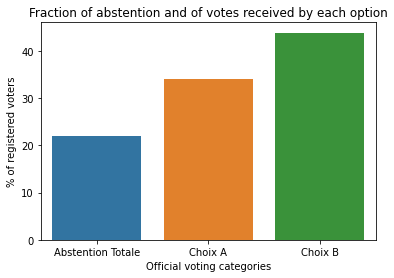

In [26]:
national=referendum[ ["Inscrits","Abstentions","Blancs et nuls","Choix A","Choix B"] ].sum()
national["Abstention Totale"] = national["Abstentions"]+national["Blancs et nuls"]
national = 100*national/national["Inscrits"]

x=["Abstention Totale","Choix A","Choix B"]
y=[national[i] for i in x]
ax=sns.barplot(x=x,y=y)
ax.set(ylabel="% of registered voters",
       xlabel="Official voting categories",
       title="Fraction of abstention and of votes received by each option")

So quite clearly, **Choice B was selected** by the people.

Let's now try to find out whether a specific part of the population favoured it.

In the following we will restrict all the analysis to the Metropole & Corsica, as not all data is available for DomToms.

In [80]:
referendum = DataReader(
    path=locations("referendum"),
    insee_code=('Code du département','Code de la commune'),
    drop_domtom=True
).content()

referendum["Abstention Totale"] = referendum["Abstentions"]+referendum["Blancs et nuls"]
for id in ["Abstention Totale","Choix A","Choix B"]:
    referendum[f"Fraction {id}"] = 100*referendum[id]/referendum["Inscrits"]

# II - Geographical distribution of the vote :

Let's try to check the geographical distribution of the french population first, then of the vote. 
Finding a correlation with urban areas might give us insigths

The 'big city' threshold at 60k is a bit arbitrary, but gave the best mapping of urban areas

In [81]:
g_ref_rec = pd.concat([geo_data,referendum,recensement],axis=1)
big_cities=g_ref_rec[g_ref_rec['P13_POP']>60000].geometry

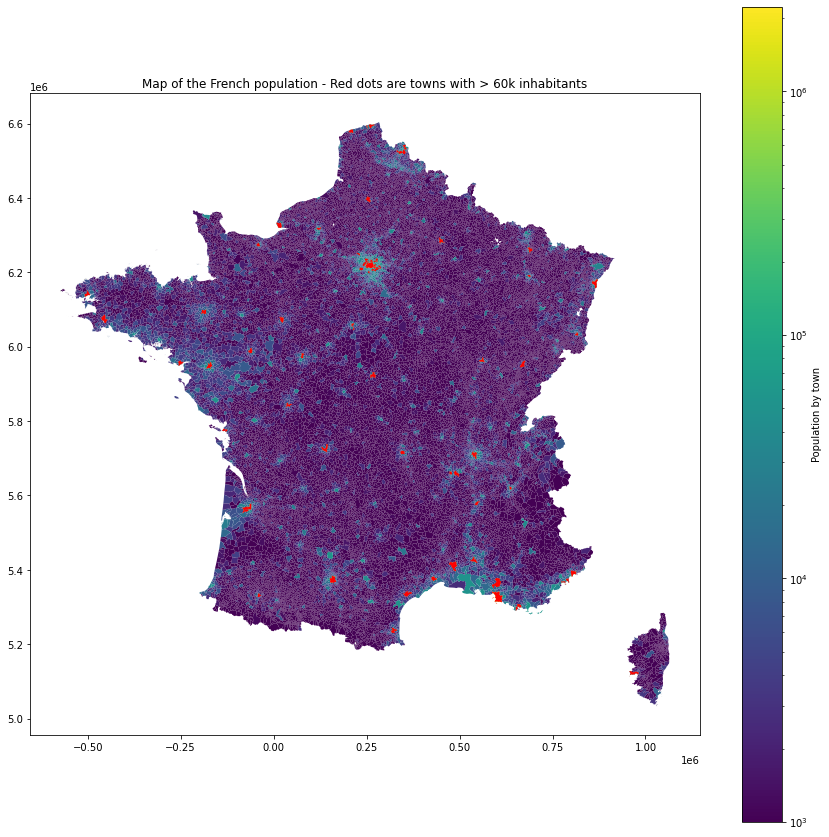

In [82]:
ax = g_ref_rec.plot(column='P13_POP',figsize=(15,15),edgecolor='none',legend=True,
                     norm=matplotlib.colors.LogNorm(vmin=1000, vmax=g_ref_rec.P13_POP.max()),
                     legend_kwds={'label': "Population by town"}
             ) 
big_cities.plot(color='red',ax=ax,markersize=5,marker='o')
plt.title("Map of the French population - Red dots are towns with > 60k inhabitants")
plt.show()

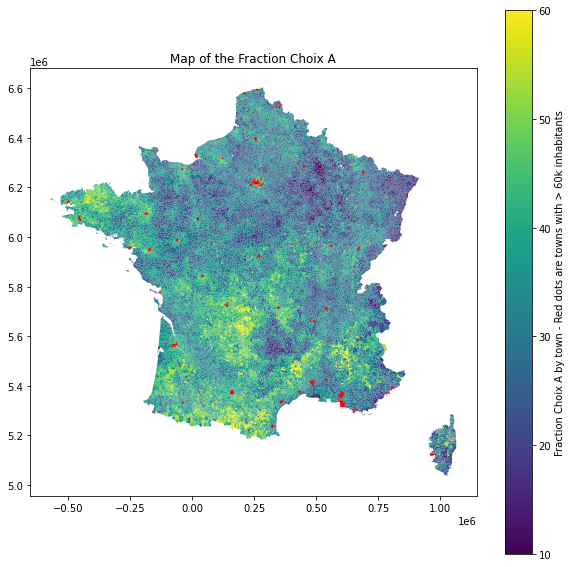

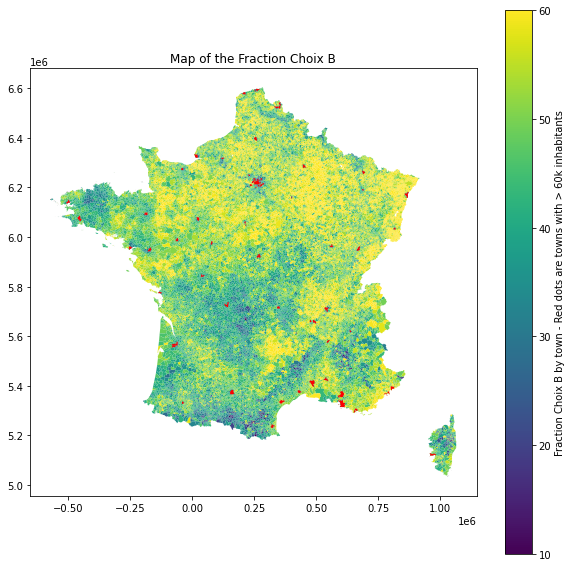

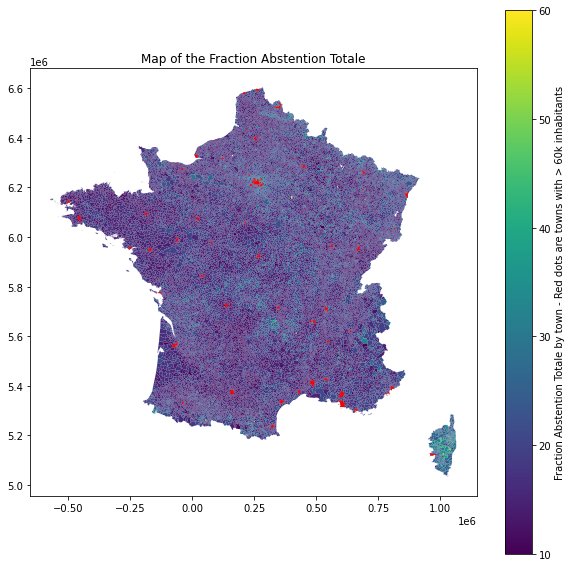

In [85]:
names=[f'Fraction {id}' for id in ['Choix A','Choix B','Abstention Totale']]

for id in names:
    ax = g_ref_rec.plot(
        column=id,figsize=(10,10),edgecolor='none',legend=True,
        legend_kwds={'label': f"{id} by town"},
        vmin=10,vmax=60
    ) 
    big_cities.plot(color='red',ax=ax,markersize=5,marker='o')
    plt.title(f"Map of the {id} - Red dots are towns with > 60k inhabitants")
    plt.show()

So there is no clear link with rural/urban areas, however I'll run it again without the big cities to get a better idea of the Parisian region.

There is some trend Sout West/North East, with the latter being much more favourable to option B.

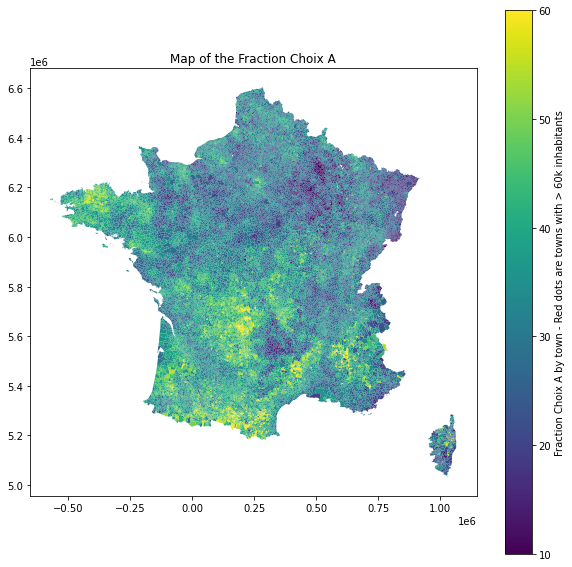

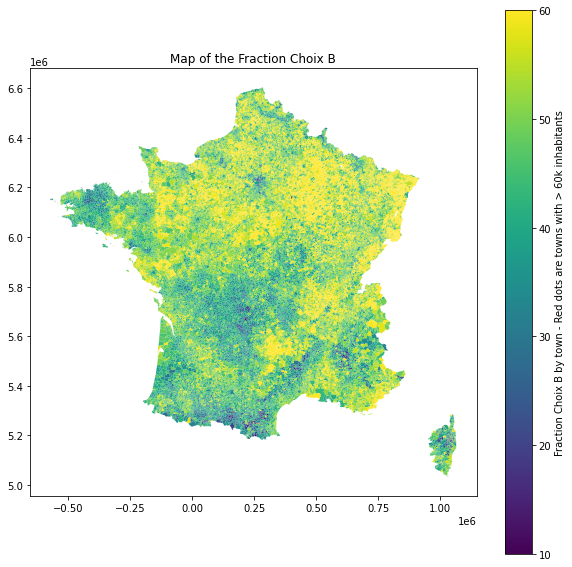

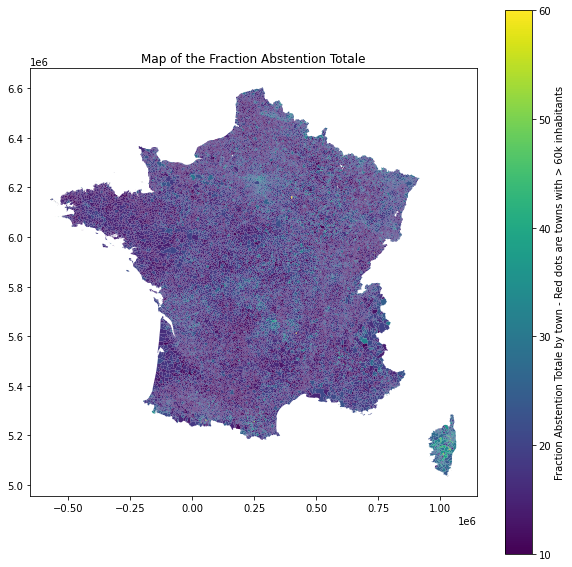

In [86]:
for id in names:
    ax = g_ref_rec.plot(
        column=id,figsize=(10,10),edgecolor='none',legend=True,
        legend_kwds={'label': f"{id} by town"},
        vmin=10,vmax=60
    ) 
    plt.title(f"Map of the {id} - Red dots are towns with > 60k inhabitants")
    plt.show()

Parisian region is one of the most defavourable to Option B, it tends to favours Option A and abstain much more. 

# III - Check gender & age imbalance

Let's do two things at first :
* Distribution of vote in towns that are mostly male/female
* Scatter plot of fraction of each option vs mean age

This should tell us whether we can make the (unreasonnable) assumption that every age class/gender votes the them in a given town. If it was to be the case we could plot age pyramids easily.

I also compute some weights so that each town is fairly represented in the plot, in every plotting option that supports it (it's not always the case)

In [143]:
g_ref_rec['MainGender'] = np.where(g_ref_rec['P13_POPH'] > g_ref_rec['P13_POPF'], 'Male', 'Female')
g_ref_rec['weights'] = g_ref_rec['P13_POPH']/g_ref_rec['P13_POPH'].sum()

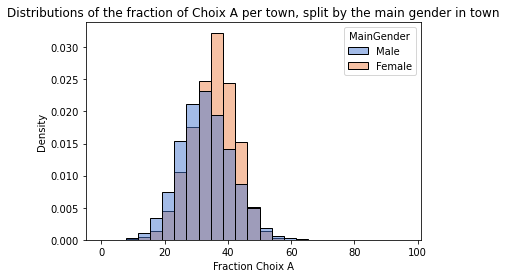

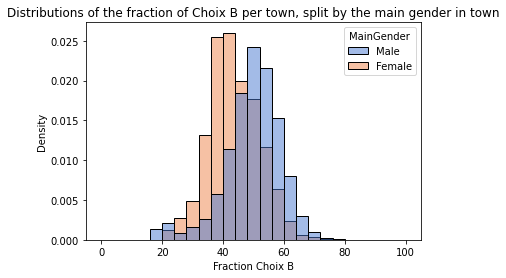

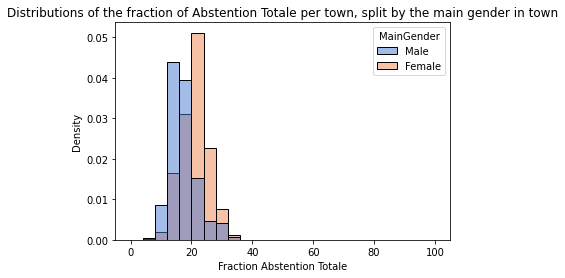

In [145]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.histplot(data=g_ref_rec,x=f'Fraction {id}',weights='weights',hue='MainGender',stat='density',palette='muted',bins=25)
    plt.title(f"Distributions of the fraction of {id} per town, split by the main gender in town")
    plt.show()

### Towns that are mostly female tend to abstain more, and while Female voters still favor Choice B they are less determined.

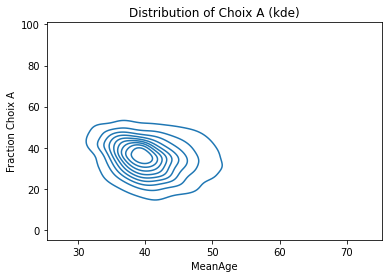

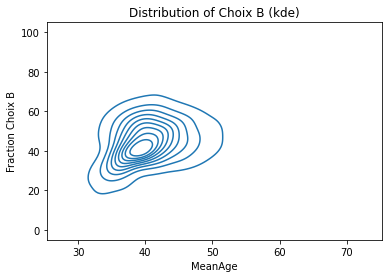

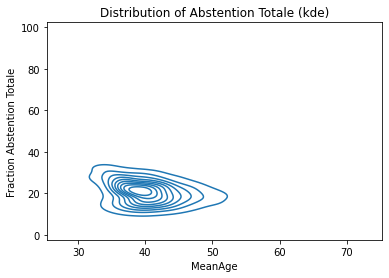

In [155]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.kdeplot(data=g_ref_rec,y=f'Fraction {id}',x="MeanAge",weights='weights',levels=10)
    plt.title(f"Distribution of {id} (kde)")
    plt.show()

I prefered KDE plots rather than standard scatter plots that are too cluttered, given the number of towns. 
Before going to a regression plot to confirm the findings let's split this by gender.

### There seem to be a correlation between age and chosing Choice B, older people being more in favor of it and also voting (slightly) more.

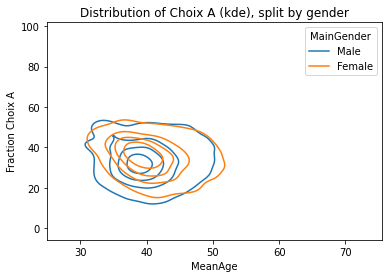

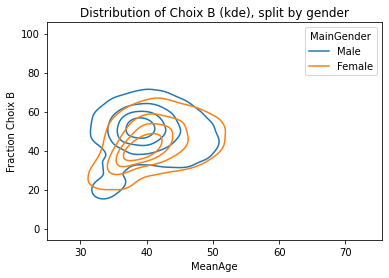

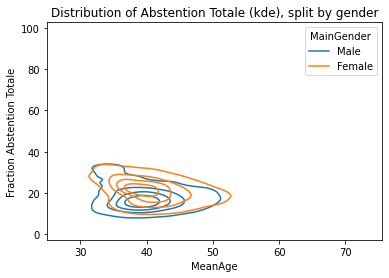

In [157]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.kdeplot(data=g_ref_rec,y=f'Fraction {id}',x="MeanAge",weights='weights',hue='MainGender',levels=5)
    plt.title(f"Distribution of {id} (kde), split by gender")
    plt.show()

### Furthermore this correlation seems to be mostly driven by women